In [1]:
from csv_psfs import *
import svd_model as svm

import forward_model as fm

import numpy as np
import scipy.io

# for a bit of investigation into the process surrounding the SVD
#import pdb
from IPython.core.debugger import set_trace

# load my own module for loading the PSFs
import sys
sys.path.append("../tensorflow")
import load_PSFs

# My SVD
Grab the PSF stack, do the SVD, test on the hydra. Simple as.

In [2]:
#psf_directory = "/home/dshteinbok/nV3_PSFs"
psf_directory = "/home/dshteinbok/nV3_PSFs_large"
psf_meta = "/home/dshteinbok/nV3_PSFs_meta/PSF_Shifts.csv"
# TODO: where to save

# (height, width)
#img_dims = (800, 1280)

# ACTUALLY should be (width, height) to be compatible with load_PSFs
#img_dims = (1280, 800)
img_dims = (1280, 1280)

In [3]:
psfs = load_from_dir(psf_directory)

In [4]:
psfs.shape

(64, 64, 29)

In [5]:
# load the PSFs
#psfs = pad_as_center(load_from_dir(psf_directory), img_dims[0], img_dims[1])
psfs = pad_as_center(load_from_dir(psf_directory), img_dims[1], img_dims[0])
#psfs = load_PSFs.load_PSFs_csv(psf_directory, psf_meta, img_dims)[:,:,:,0]

**ERROR DISCOVERED IN WALLER PAPER:** Waller et al. basically use the location of the brightest point in each of the PSFs to interpolate the PSF for all other points (specifically they interpolate the weights by which they must multiply each "kernel" for all points from the ones that they observe). However, they actually have all their PSFs centered in the frame, so all but one of their PSFs are in the center. The other PSF is (1,1) away from the center. Thus, all points within any quadrant exhibit shift-invariance.

To solve this, you need to be careful about how you pad your PSF. You don't want it to be in the center, but rather you want it shifted to wherever the light ends up.

In our case, according to the spec, this should be 1 pixel for every 0.8 um. 

In [6]:
ref_image_index=23
#set_trace()
psfs_reg,shifts=svm.register_psfs(psfs, psfs[:,:,ref_image_index],dct_on=False)

registering

done registering



In [7]:
shifts

{0: [0, -7],
 1: [5, -10],
 2: [1, -11],
 3: [15, -5],
 4: [16, -5],
 5: [15, -5],
 6: [13, 1],
 7: [13, -2],
 8: [10, 1],
 9: [12, -2],
 10: [13, -9],
 11: [0, -4],
 12: [13, -7],
 13: [10, -10],
 14: [12, -10],
 15: [8, -7],
 16: [7, -9],
 17: [7, -12],
 18: [7, -12],
 19: [8, 1],
 20: [7, 4],
 21: [7, 3],
 22: [0, -5],
 23: [1, 1],
 24: [1, -2],
 25: [4, 2],
 26: [1, 1],
 27: [1, -9],
 28: [2, -7]}

In [8]:
metaman = load_PSFs.MetaMan(psf_meta)

In [9]:
rank=28
comps, weights_interp=svm.calc_svd(psfs_reg,metaman.shifts,rank)
#comps, weights_interp=svm.calc_svd(psfs_reg,shifts,rank)

creating matrix

done

starting svd...

check values of ymat
interpolating...

done




In [10]:
metaman.shifts

{1: [250, 0],
 2: [500, 0],
 3: [750, 0],
 4: [250, -250],
 5: [500, -250],
 6: [250, -500],
 7: [500, -500],
 8: [250, 250],
 9: [500, 250],
 10: [250, 500],
 11: [500, 500],
 12: [-250, 0],
 13: [-500, 0],
 14: [-750, 0],
 15: [-250, -250],
 16: [-500, -250],
 17: [-250, -500],
 18: [-500, -500],
 19: [-250, 250],
 20: [-500, 250],
 21: [-250, 500],
 22: [-500, 500],
 23: [0, 0],
 24: [0, 250],
 25: [0, 500],
 26: [0, 750],
 27: [0, -250],
 28: [0, -500],
 29: [0, -750]}

In [11]:
# Normalize weights to have maximum sum through rank of 1
weights_norm = np.sum(weights_interp[weights_interp.shape[0]//2-1,weights_interp.shape[1]//2-1,:],0).max()
weights = weights_interp/weights_norm;

#normalize by norm of all stack. Can also try normalizing by max of all stack or by norm of each slice
h=comps/np.linalg.norm(np.ravel(comps))

In [12]:
h.shape

(1280, 1280, 28)

In [13]:
weights.shape

(1280, 1280, 28)

In [14]:
h_dict = {"array_out": h}
scipy.io.savemat("../data/nV3_h.mat", h_dict)

In [15]:
weights_dict = {"array_out": weights}
scipy.io.savemat("../data/nV3_weights.mat", weights_dict)

Now, view each of the PSFs at the 12 positions:

In [16]:
psfs_reg.shape

(1280, 1280, 29)

(649, 633)
(649, 633)
(649, 633)
(649, 633)
(649, 633)
(648, 635)
(647, 635)
(646, 635)
(649, 633)
(647, 635)
(647, 634)
(645, 633)


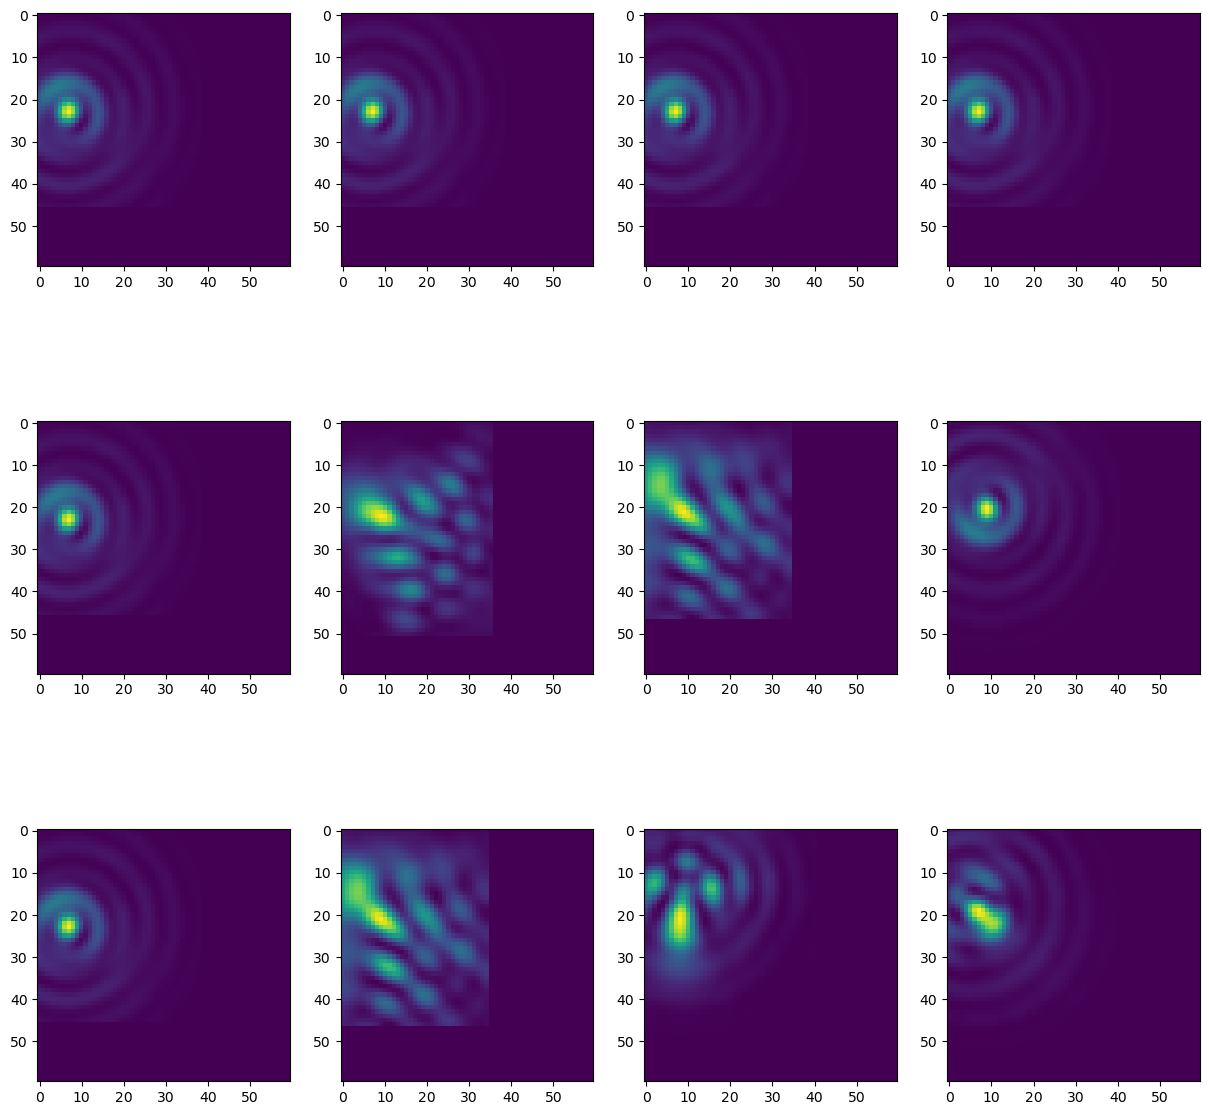

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 4, figsize=(15,15))
for row in range(3):
    for column in range(4):
        axs[row, column].imshow(psfs_reg[626:686,626:686,row*column])
        print(np.unravel_index(np.argmax(psfs_reg[:,:,row*column]), (800,1280)))

In [18]:
h.shape

(1280, 1280, 28)

In [19]:
weights.shape

(1280, 1280, 28)